# Predicting cyberattacks - HAI 20.07 dataset

This Jupyter notebook explores various approaches for implementing machine learning algorithms that detects attacks in the HAI 20.07 dataset.

Technical details : [here](https://github.com/icsdataset/hai/blob/master/hai_dataset_technical_details.pdf)

## Downloading the dataset

In this section, we will be looking at how to download the different CSV files, and how to convert them as pandas dataframes.

In [1]:
!mkdir -p ./data
!wget -O - "https://raw.githubusercontent.com/icsdataset/hai/master/hai-20.07/test1.csv.gz" | gunzip > ./data/test1.csv
!wget -O - "https://raw.githubusercontent.com/icsdataset/hai/master/hai-20.07/test2.csv.gz" | gunzip > ./data/test2.csv
!wget -O - "https://raw.githubusercontent.com/icsdataset/hai/master/hai-20.07/train1.csv.gz" | gunzip > ./data/train1.csv
!wget -O - "https://raw.githubusercontent.com/icsdataset/hai/master/hai-20.07/train2.csv.gz" | gunzip > ./data/train2.csv

--2024-08-22 17:09:09--  https://raw.githubusercontent.com/icsdataset/hai/master/hai-20.07/test1.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32813703 (31M) [application/octet-stream]
Saving to: ‘STDOUT’

-                   100%[===================>]  31.29M  6.73MB/s    in 4.7s    

2024-08-22 17:09:14 (6.72 MB/s) - written to stdout [32813703/32813703]

--2024-08-22 17:09:14--  https://raw.githubusercontent.com/icsdataset/hai/master/hai-20.07/test2.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16907509 (16M) 

## Statistics about the datasets

Here, we will try to visualize the different downloaded datasets, and its metadatas.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import collections

import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split

2024-08-22 17:09:29.253986: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 17:09:29.272379: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 17:09:29.277944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 17:09:29.291736: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-22 17:09:30.230755: W tensorflow/compiler/tf2

Here, using a dedicated validation dataset from the training dataset itself (and not from the testing one) is due to the fact that "normal" data in the testing dataset may be affected by precedent attacks on the system, and thus give a very innacurate validation loss score.

In [3]:
train = []
validation = []
test = []
labels = []

dataset_ids = [1, 2]

for dataset_id in dataset_ids:
    train_data, validation_data = train_test_split(
        pd.read_csv(f"./data/train{dataset_id}.csv", sep=";", index_col="time", usecols=list(range(60))).values,
        # test size => validation size in this case
        test_size=0.1, random_state=42)

    train.append(train_data)
    validation.append(validation_data)
    
    test_data = pd.read_csv(f"./data/test{dataset_id}.csv", sep=";", index_col="time").values

    test.append(test_data[:, 0:-4])
    labels.append(test_data[:, -4:])

Normalize the data on [0, 1]

In [4]:
for i in range(len(dataset_ids)):
    reduced_min = np.min(train[i], 0)
    reduced_max = np.max(train[i], 0)

    asset_range = reduced_max - reduced_min

    # Normalizing while making sure there is no divison by zero
    train[i] = np.divide((train[i] - reduced_min), asset_range, where=asset_range != 0)
    test[i] = np.divide((test[i] - reduced_min), asset_range, where=asset_range != 0)
    validation[i] = np.divide((validation[i] - reduced_min), asset_range, where=asset_range != 0)
    
    train[i] = tf.cast(train[i], tf.float32)
    test[i] = tf.cast(test[i], tf.float32)
    validation[i] = tf.cast(validation[i], tf.float32)

2024-08-22 17:09:42.121034: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11365 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:08:00.0, compute capability: 6.1
2024-08-22 17:09:42.121734: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 11365 MB memory:  -> device: 1, name: NVIDIA TITAN Xp, pci bus id: 0000:09:00.0, compute capability: 6.1
2024-08-22 17:09:42.122279: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 11365 MB memory:  -> device: 2, name: NVIDIA TITAN Xp, pci bus id: 0000:84:00.0, compute capability: 6.1
2024-08-22 17:09:42.122880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 11365 MB memory:  -> device: 3, name: NVIDIA TITAN Xp, pci bus id: 0000:88:00.0, comp

## Build an anomaly detection model

Here the goal is to mesure at a given time and for a given sensor how abnormal its value is compared to its normal behaviour.

For this, we are going to use an autoencoder model. The goal is simple : we train the model on normal training data, and the model is trying to reproduce the normal data. The hypothesis is that the model will missbehave when given abnormal data (for example during an attack on the system).

In this case, we will be building multiple models in order to get a better view of the results.

In [5]:
class AttackDetectionModel(Model):
    def __init__(self, layers_sizes):
        super(AttackDetectionModel, self).__init__()

        # Layers sizes : [Input/Ouput size, hidden layer, Bottleneck size]
        # Only one hidden layer because of the small number of sensors
        
        self.encoder = tf.keras.Sequential([
            layers.Dense(layers_sizes[1], activation="relu"), # Encoder hidden layer
            layers.Dense(layers_sizes[2], activation="relu")  # Bottleneck (lower-dimensionnal representation)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Dense(layers_sizes[1], activation="relu"), # Decoder hidden layer
            layers.Dense(layers_sizes[0], activation="sigmoid")  # Output of the model
        ])

    def call(self, sensors):
        encoded = self.encoder(sensors)
        decoded = self.decoder(encoded)
        return decoded

models = []
# Compare the results from different models
number_models = 5

# models => list of X groups of models => multiple models (two for the two datasets) => model + history

for i in range(number_models):
    models.append([])
    # Each training dataset has different schedule routines, and thus needs to be trained on his own
    for j in range(len(dataset_ids)):
        models[i].append({})
        models[i][j]["model"] = AttackDetectionModel([train[0].shape[1], 35, 20])
        models[i][j]["model"].compile(optimizer='adam', loss='mae')
        models[i][j]["history"] = models[i][j]["model"].fit(train[j], train[j],
                  epochs=10,
                  batch_size=512,
                  validation_data=(validation[j], validation[j]),
                  shuffle=True)

Epoch 1/10


I0000 00:00:1724314184.550104 2264946 service.cc:146] XLA service 0x7fa6c4008560 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724314184.550141 2264946 service.cc:154]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
I0000 00:00:1724314184.550145 2264946 service.cc:154]   StreamExecutor device (1): NVIDIA TITAN Xp, Compute Capability 6.1
I0000 00:00:1724314184.550148 2264946 service.cc:154]   StreamExecutor device (2): NVIDIA TITAN Xp, Compute Capability 6.1
I0000 00:00:1724314184.550151 2264946 service.cc:154]   StreamExecutor device (3): NVIDIA TITAN Xp, Compute Capability 6.1
I0000 00:00:1724314184.550153 2264946 service.cc:154]   StreamExecutor device (4): NVIDIA TITAN Xp, Compute Capability 6.1
2024-08-22 17:09:44.597233: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-22 17:09:46.953040: I e

 71/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.2573

I0000 00:00:1724314187.884712 2264946 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


545/545 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1447 - val_loss: 0.0520
Epoch 2/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0477 - val_loss: 0.0403
Epoch 3/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0382 - val_loss: 0.0350
Epoch 4/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0344 - val_loss: 0.0328
Epoch 5/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0323 - val_loss: 0.0320
Epoch 6/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0313 - val_loss: 0.0297
Epoch 7/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0293 - val_loss: 0.0283
Epoch 8/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0279 - val_loss: 0.0267
Epoch 9/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0259 - val_loss: 0.0248
Epoch 10/10
545/545 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0244 - val_loss: 0.0241
Epoch 1/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.1734 - val_loss: 0.0619
Epoch 2/10
424/424 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.05

Training and validation loss of the first group of models as an example

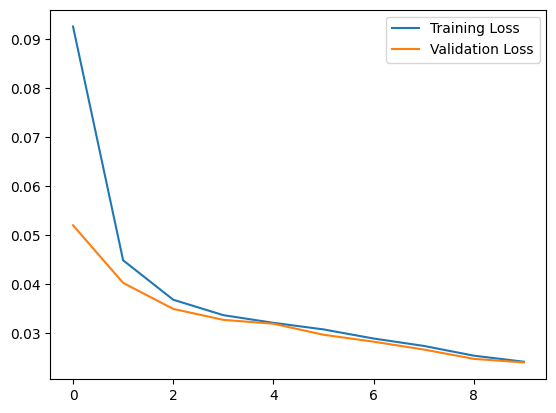

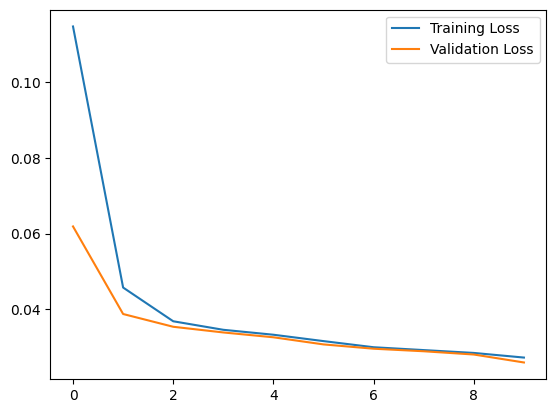

In [6]:
for i in range(len(dataset_ids)):
    plt.plot(models[0][i]["history"].history["loss"], label="Training Loss")
    plt.plot(models[0][i]["history"].history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.show()

Getting every reconstructions of the testing data from the models

In [7]:
predictions = [[models[j][i]["model"].predict(test[i]) for i in range(len(dataset_ids))]for j in range(len(models))]

9113/9113 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
9113/9113 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
9113/9113 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step
9113/9113 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
9113/9113 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
4782/4782 ━━━━━━━━━━━━━━━━━━━━ 6s 1ms/step


Function for calculating the loss between the real testing data, and the reconstruction from a given model

In [8]:
def test_loss(dataset_id, iteration):
    # Squared difference
    return np.square(test[dataset_id] - predictions[iteration][dataset_id])

Calculating all the losses

In [9]:
loss = [[test_loss(i, j) for i in range(len(dataset_ids))] for j in range(number_models)]

In this step, we are splitting every attacks from the losses. This done thanks to the testing labels indicating when the system did detect an attack on the system.

We are also adding padding before and after the attack in order not to loose information.

`attack (list of values of sensors on a timeline) = buffer + labels indicating attack + buffer (from loss calculus above)`

In [10]:
# Generating the ids of the different attacks (cf. detailed pdf of the dataset)
attack_ids = ["A" + j + str(i).zfill(2) for j in ["1", "2"] for i in range(1, 20)]

buffered_attacks = {}

start_buffer = 20
end_buffer = 200

for j in range(number_models):
    attack_iterator = iter(attack_ids)
    reading_attack = False
    
    for dataset_id, dataset in enumerate(labels):
        for i, label_sample in enumerate(dataset):
            if label_sample[0] == 1 and not reading_attack:
                reading_attack = True
                attack_start = i
            elif label_sample[0] == 0 and reading_attack:
                reading_attack = False
                attack = next(attack_iterator)

                if attack not in buffered_attacks.keys():
                    buffered_attacks[attack] = [loss[j][dataset_id][attack_start - start_buffer:i + end_buffer]]
                else:
                    buffered_attacks[attack].append(loss[j][dataset_id][attack_start - start_buffer:i + end_buffer])

This function is giving an indicative threshold for "abnormal loss" for a given vector on a timeline

In [11]:
def threshold(vector):
    return np.mean(vector) + np.std(vector)

Function to transform each value of the vector to boolean of (above threshold or not)

In [12]:
def crossing_threshold(vector):
    return vector - threshold(vector) > 0

This function is deciding if a sensor is abnormal on a given timeline (returning boolean), depending on two criteria :
- The sensor shouldn't be abnormal before the attack (we can argue that the values of the sensor cannot really be trusted)
- The sensor should reach a minimum of abnormal "quantity" during the attack

In [13]:
# Input : Vector of boolean "is above threshold for a given timestamp"
def is_sensor_affected(vector):
    # Criteria 1 : Not already abnormal before the attack
    # Criteria 2 : Reach abnormal level during the attack (or during the buffer time at the end)
    min_percentage_abn_duration = 0.15
    
    return (np.sum(vector[:start_buffer]) == 0) and (np.sum(vector[start_buffer:]) / len(vector[start_buffer:]) >= min_percentage_abn_duration)

Here, we are keeping the same shape of `(buffer + lenght of labels showing attack + buffer) x sensor_amount`, but changing the content.

For a given attack :

If a sensor is considered "affected" (cf. above function) by a given attack, each of its values will become booleans, depending on if they are "abnormal" or not.

If the sensor is not considered affected, it is filled with zeros.

In [14]:
attacks_sensors = {}

for i in range(number_models):
    for attack_id, sensors_list in buffered_attacks.items():
        crossing_sensors = np.apply_along_axis(crossing_threshold, 0, sensors_list[i])
        affected_sensors = np.apply_along_axis(is_sensor_affected, 0, crossing_sensors)

        if attack_id not in attacks_sensors.keys():
            attacks_sensors[attack_id] = [np.empty(crossing_sensors.shape)]
        else:
            attacks_sensors[attack_id].append(np.empty(crossing_sensors.shape))
        
        for column_id in range(crossing_sensors.shape[1]):
            if affected_sensors[column_id]:
                attacks_sensors[attack_id][i][:, column_id] = crossing_sensors[:, column_id]
            else:
                # Filling the sensor values with zeros instead of removing it in order to keep the index of each sensor correct
                attacks_sensors[attack_id][i][:, column_id] = np.zeros((crossing_sensors.shape[0],))

This piece of code is filling with zeros the "small peeks" of abnormal timestamps. If they are not considered big enough, they are considered not meaningfull enough.

In [15]:
# Minimum size (in seconds) of an "abnormal peek" during an attack for it to be considered "meaningfull"
min_peek_lenght = 10

for attack_id, sensors_list in attacks_sensors.items():
    for j in range(number_models):
        for sensor_id, sensor in enumerate(sensors_list[j].T):
            reading_peek = False
            
            for i, value in enumerate(sensor):
                if value and not reading_peek:
                    reading_peek = True
                    start_peek = i
                elif not value and reading_peek:
                    reading_peek = False
    
                    # Replace small peeks with zeros
                    if i - start_peek < min_peek_lenght:
                        attacks_sensors[attack_id][j][start_peek:i, sensor_id].fill(0)
    
            if reading_peek and len(sensor) - start_peek < min_peek_lenght:
                attacks_sensors[attack_id][j][start_peek:len(sensor), sensor_id].fill(0)

Function giving correlation score between two sensors. The shift window is the amount of time (is seconds) we allow the sensors to use in order to shift the two signals. In other words, we give them X seconds of delay (in both directions) for them to produce the best possible correlation score (but this shift will not be kept later, it's just a small help for not being too harsh on the correlations).

In [16]:
# Gap of time for taking into account "delayed impacts" between two sensors
shift_window = 5

# Function to determine if two sensors are influencing each other
def correlation(sensor_1, sensor_2):
    # Adding time padding
    sensor_1 = np.append(np.zeros((shift_window)), sensor_1)
    sensor_1 = np.append(sensor_1, np.zeros((shift_window)))

    return np.correlate(sensor_1, sensor_2, mode="valid")

This code is calculating the correlation score between every possible couple of sensors. If it is not high enough, this couple of sensors for this given attack will not be taken into account.

Next, we will select the first timestamp where both sensors are abnormal at the same time. 

Finally, we will look at the timestamp right before the "first meeting timestamp". If one sensor is abnormal and the other one not, we assume that this first sensor is "affecting" the second one. If they both start at the same time, we assume that they influence each-other.

Reading : (1, 2) = sensor 1 is affecting sensor 2

If both are affecting each-other, two relations (1, 2) and (2, 1) will be added to the list.

In [17]:
attack_chains = {}

relationship_min_value = 20

for attack_id, sensors_list in attacks_sensors.items():
    attack_chains[attack_id] = []

    for i, sensors in enumerate(sensors_list):
        attack_chains[attack_id].append([])
        
        for sensor_1 in range(sensors.shape[1] - 1):
            for sensor_2 in range(sensor_1 + 1, sensors.shape[1]):
                # If the two sensors are closely correlated
                if np.max(correlation(sensors[:, sensor_1], sensors[:, sensor_2])) >= relationship_min_value:
                    first_meeting_timestamp = None
                    # First timestamp where both sensors are abnormal
                    for timestamp in range(sensors.shape[0]):
                        if sensors[timestamp, sensor_1] and sensors[timestamp, sensor_2]:
                            first_meeting_timestamp = timestamp
                            break
    
                    # NOTE : The case were the two sensors are correlated (with a shift) but in real life never abnormal
                    # at the same time never came by, so it is not taken into account here
                    
                    # If there is a meeting timestamp
                    if first_meeting_timestamp != None:
                        # If the two sensors started being abnormal at the same time
                        if first_meeting_timestamp == 0 or (not sensors[first_meeting_timestamp-1, sensor_1] and not sensors[first_meeting_timestamp-1, sensor_2]):
                            # Then both sensors are influencing each other
                            attack_chains[attack_id][i].append((sensor_1, sensor_2))
                            attack_chains[attack_id][i].append((sensor_2, sensor_1))
    
                        # If the first sensor was abnormal right before first meeting point
                        elif sensors[first_meeting_timestamp-1, sensor_1]:
                            # Then the first sensor is influencing the second one
                            attack_chains[attack_id][i].append((sensor_1, sensor_2))

    
                        # If the second sensor was abnormal right before first meeting point
                        elif sensors[first_meeting_timestamp-1, sensor_2]:
                            # Then the second sensor is influencing the first one
                            attack_chains[attack_id][i].append((sensor_2, sensor_1))

This is where we finally use the multiple models : because one model might be incorrect in some edge cases, we cannot fully trust it in order to get the relationships we need.

In order to fix this situation, we chose earlier to train multiple identical models, in order to see the reccurent behaviour accross the models, and what decisions seems to be edge-cases.

Here, we are checking how many times a relationship between two sensors is detected by the different models.

In this case, if less than half of the models detected it, is it considered irrelevant.

In [19]:
kept_relations_amount = 0
unkept_relations_amount = 0

seen = {}
kept_relations = {}

for attack_id, chains in attack_chains.items():
    seen[attack_id] = []
    kept_relations[attack_id] = []
    for i, couples in enumerate(chains):
        for couple in couples:
            if couple not in seen[attack_id]:
                occurences = 1

                for j, other_chain in enumerate(chains):
                    if i != j:
                        if couple in other_chain:
                            occurences += 1
                            
                if occurences >= number_models * 0.5:
                    kept_relations_amount += 1
                    kept_relations[attack_id].append(couple)
                else:
                    unkept_relations_amount += 1
                    
                seen[attack_id].append(couple)

In [26]:
print("Relations appearing accross half or more models :", kept_relations_amount)
print("Relations not appearing enough accross multiple models :", unkept_relations_amount)
print("\n".join([attack_id + " : " + str(couples) for attack_id, couples in kept_relations.items()]))

Relations appearing accross half or more models : 627
Relations not appearing enough accross multiple models : 5981
A101 : [(23, 1), (24, 1), (14, 12), (23, 12), (24, 12), (15, 14), (14, 23), (14, 24), (14, 27), (14, 57), (15, 23), (15, 24), (15, 27), (15, 57), (23, 24), (27, 23), (57, 23), (27, 24), (57, 24), (27, 57), (52, 54)]
A102 : [(23, 1), (24, 1), (14, 20), (14, 23), (14, 24), (20, 21), (20, 22), (20, 27), (20, 57), (21, 22), (21, 27), (23, 22), (24, 22), (57, 22), (23, 24), (23, 57), (24, 57), (23, 2), (24, 2), (29, 7), (14, 22), (14, 52), (20, 24), (20, 52), (21, 57), (23, 52), (24, 52)]
A103 : [(12, 1), (13, 1), (15, 1), (29, 12), (58, 12), (58, 13), (14, 15), (14, 20), (14, 21), (14, 23), (14, 24), (14, 27), (14, 57), (20, 15), (15, 21), (15, 57), (20, 21), (20, 23), (20, 24), (20, 27), (20, 57), (21, 23), (21, 24), (21, 27), (21, 57), (27, 23), (57, 23), (27, 24), (57, 24), (1, 21), (1, 27), (15, 23), (15, 24), (15, 27), (23, 24), (27, 57)]
A104 : [(3, 13), (52, 54), (54, 